In [1]:
from pyabc import (ABCSMC, Distribution, RV, distance_functions)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.distance_functions import WeightedPNormDistance
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tempfile
import pandas as pd
import scipy as sp
import numpy as np
import subprocess
from io import BytesIO
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "ik1.db"))

In [2]:
def simulate(channel, **pars):
    """Wrapper to simulate the myokit model.
    
    Simulates in a subprocess running python2 by passing
    parameters as arguments to (another) wrapper script.
    
    Args:
        channel: Ion channel to parameterise.
        pars: Parameters as kwargs.
        
    Returns:
        Dataframe with simulated output or empty if
        the simulation failed.
    """
    myokit_python = ("/Users/charles/miniconda3/envs" +
                     "/ion_channel_ABC/bin/python")
    script = "run_channel.py"
    args = [myokit_python, script]
    args.append(channel)
    for p in pars:
        try:
            args.append("-" + str(p))
            args.append(str(pars[p]))
        except:
            print("Error: " +
                  "args is " + str(args))
    re = subprocess.run(args, stdout=subprocess.PIPE)
    if len(re.stdout) > 0:
        d = pd.read_table(BytesIO(re.stdout),
                          delim_whitespace=True,
                          header=0, index_col=0)
        d = d.to_dict()['y']
    else:
        d = {}
    return d

In [3]:
myokit_python = ("/Users/charles/miniconda3/envs" +
                 "/ion_channel_ABC/bin/python")
args = [myokit_python, "get_measurements.py"]
args.append('ik1')
re = subprocess.run(args, stdout=subprocess.PIPE)
measurements = pd.read_table(BytesIO(re.stdout),
                             delim_whitespace=True,
                             header=0, index_col=0)
measurements = measurements.to_dict()['y']

In [4]:
limits = dict(g_K1=(0, 0.5),
              k_1=(-1000, 1000),
              k_2=(0, 100),
              k_3=(0, 1),
              k_4=(0, 0.1))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [5]:
"""
def distance(sim, obs):
    obs = pd.DataFrame(obs)
    sim = pd.DataFrame(sim)
    if sim.empty:
        return float("inf")
    dist = 0
    for i in obs.exp.unique():
        try:
            err = np.sum(np.square(obs[obs.exp == i].y - sim[sim.exp == i].y))
        except:
            return float("inf")
        err = pow(err / len(obs[obs.exp == i].y), 0.5)
        err /= np.ptp(obs[obs.exp == i].y)
        dist += err
    return dist
"""
distance = WeightedPNormDistance(p=2, adaptive=True)

In [6]:
def simulate_pyabc(parameter):
    res = simulate('ik1', **parameter)
    return res

In [7]:
abc = ABCSMC(simulate_pyabc, prior, distance,
             population_size=AdaptivePopulationSize(200, 0.2, max_population_size=5000))
abc_id = abc.new(db_path, measurements)

INFO:Epsilon:initial epsilon is 16.821602338864963
INFO:History:Start <ABCSMC(id=1, start_time=2018-04-25 22:12:16.075683, end_time=None)>


In [8]:
history = abc.run(max_nr_populations=10, minimum_epsilon=0.0133)

INFO:ABC:t:0 eps:16.821602338864963
INFO:ABC:t:1 eps:14.627175242335426
INFO:Adaptation:Change nr particles 200 -> 2949
INFO:ABC:t:2 eps:11.976378796468264
INFO:Adaptation:Change nr particles 2949 -> 3569


ProcessError: At least one worker is dead.

In [ ]:
from pyabc.visualization import plot_kde_matrix

df, w = abc.history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

In [ ]:
abc_continued = ABCSMC(simulate_pyabc, prior, distance,
                       population_size=AdaptivePopulationSize(100, 0.2, max_population_size=5000))
abc_continued.load(db_path, abc_id)
abc_continued.run(max_nr_populations=100, minimum_epsilon=.0133)

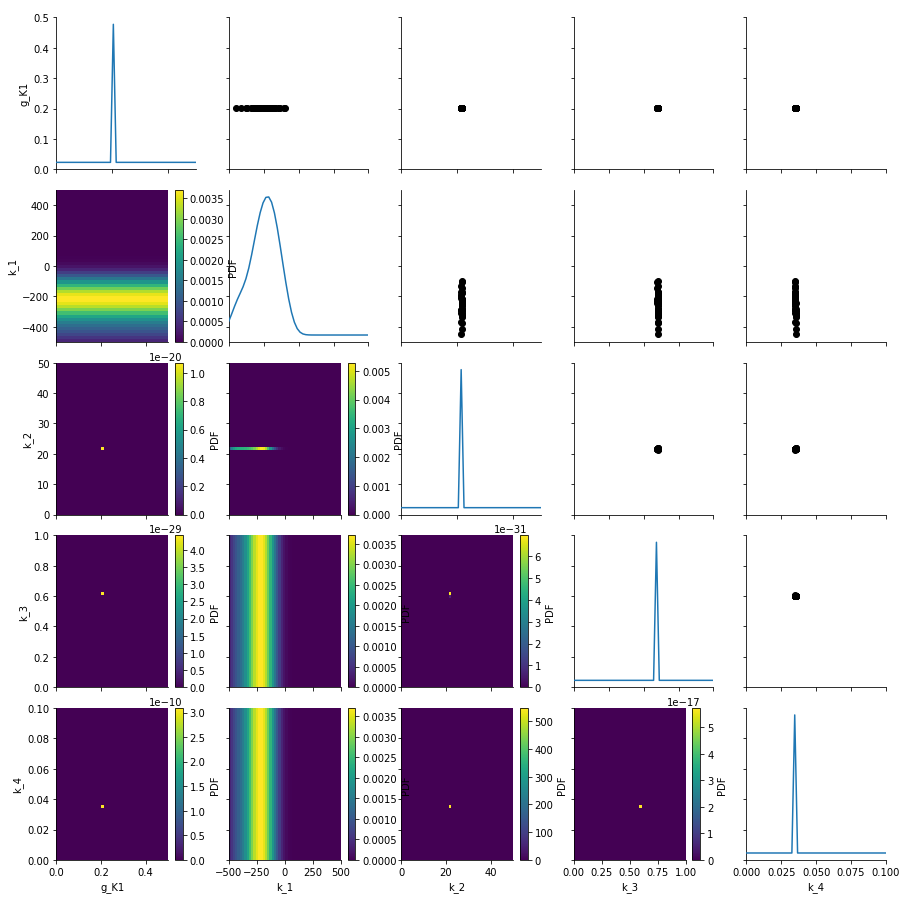

In [47]:
df, w = abc_continued.history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)